In [1]:
#импорт необходимых библиотек

import numpy as np
import pandas as pd
#import random
import itertools
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def print_col_stats(column_name):
    if not column_name:
        print(f"Column name is not given")
        return
    print(f"{column_name}")
    print(f"\t.isna().sum(): {df[column_name].isna().sum()}")
    print(f"\t.unique(), total {len(df[column_name].unique())}: {df[column_name].unique()}")
    print(f"\t.value_counts():\n{df[column_name].value_counts()}")
    
    print(f"\t.count():\n{df[column_name].count()}")
    print(f"\t.mean():\n{df[column_name].mean()}")
    print(f"\t.std():\n{df[column_name].std()}")
    print(f"\t.min():\n{df[column_name].min()}")
    print(f"\t.max():\n{df[column_name].max()}")

In [3]:
# Пути к директориям и файлам

TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [95]:
features_to_drop = ['Months since last delinquent', 'Home Ownership']
target = 'Credit Default'
TARGET_NAME = 'Credit Default'

In [5]:
# загрузка данных

train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [6]:
print(train_df.shape)
train_df.head()

(7500, 17)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
# описание данных

# Home Ownership - праововое отношение с собственностью, в которой проживает                  
# Annual Income - годовой доход
# Years in current job - полных лет на текущем месте работы    
# Tax Liens - налоговый залог
# Number of Open Accounts - количество открытых счетов
# Years of Credit History - количество (полных?) лет отслеживаемой кредитной истории
# Maximum Open Credit - размер самого большого полученного кредита
# Number of Credit Problems - количество проблем в кредитной истории
# Months since last delinquent - Месяцы с момента последнего правонарушения
# Bankruptcies                      
# Purpose - цель получения кредита
# Term - какой-то срок  
# Current Loan Amount - размер текущей задолженности
# Current Credit Balance - сколько сейчас денег на счетах?   
# Monthly Debt - затраты на обслуживание всех кредитов
# Credit Score - кредитный балл                
# Credit Default - таргет значение: даем или нет кредит      

In [8]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
train_df.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [12]:
# привеодим к 3м категориям. Owner и Tenant - это одна категория, Mortgage - другая.
# Тут рассматривается с т.з. расходов на аренду или обслуживание долга
# обслуживание долга у нас и так есть в Current Loan Amount
# вернемся к этому после построения матрицы корреляций

def prep_data__home_ownership(df, column_name='Home Ownership'):    
    df.replace({column_name: {
        'Own Home': 'owner',
        'Home Mortgage': 'mortgage',
        'Have Mortgage': 'mortgage',
        # 0 - нет информации, worst case scenario - наличие ипотеки 
        '0': 'mortgage',
        'Rent': 'tenan'}}, inplace=True)
    df['Is owner'] = df[column_name] == 'owner'
    df['Has mortgage'] = df[column_name] == 'mortgage'
    return df

In [13]:
def prep_data__annual_income(df, column_name='Annual Income'):    
    # NA меняем на медиану
    mean = round(df[column_name].mean())
    df[column_name].fillna(mean, inplace=True)
    df[column_name] = df[column_name].astype('int32')
    return df

In [14]:
def prep_data__years_in_current_job(df, column_name='Years in current job'):    
    # меняем на "полных лет на текущем месте работы"
    df.replace({column_name: {'< 1 year': '0'}}, inplace=True)
    df[column_name] = df[df[column_name].notna()][column_name].apply(lambda x: int(re.findall(r'\d+', x)[0]))
    # NA меняем на медиану
    mean = round(df[column_name].mean())
    df[column_name].fillna(mean, inplace=True)
    df[column_name] = df[column_name].astype('int32')
    return df

In [15]:
def prep_data__number_of_open_accounts(df, column_name='Number of Open Accounts'):    
    df[column_name] = df[column_name].astype('int32')
    return df

In [16]:
def prep_data__tax_liens(df, column_name='Tax Liens'):    
    df[column_name] = df[column_name].astype('int32')
    # значение переводим в Boolean, т.к. 0 подавляющее количесество
    df[column_name] = df[column_name].astype('bool')
    return df

In [17]:
def prep_data__years_of_credit_history(df, column_name='Years of Credit History'):    
    # меняем на "полных лет кредитной истории"
    df[column_name] = df[column_name].astype('int32')
    return df

In [18]:
def prep_data__maximum_open_credit(df, column_name='Maximum Open Credit'):    
    df[column_name] = df[column_name].astype('int32')
    return df

In [19]:
def prep_data__number_of_credit_problems(df, column_name='Number of Credit Problems'):    
    df[column_name] = df[column_name].astype('int32')
    # значение переводим в Boolean, т.к. 0 подавляющее количесество
    df[column_name] = df[column_name].astype('bool')
    return df

In [20]:
# Months since last delinquent - Месяцы с момента последнего правонарушения

# 0 - это не нарушал или нарушил в этом месяце? будем считать, что не нарушал
# тогда NA можно заполнить 0

def prep_data__months_since_last_delinquent(df, column_name='Months since last delinquent'):
    df[column_name].fillna(0.0, inplace=True)
    df[column_name] = df[column_name].astype('int32')
    df['Is delinquent'] = df[column_name] > 0
    return df

In [21]:
# Bankruptcies - Количество банкроств, которые допустил клиент

def prep_data__bankruptcies(df, column_name='Bankruptcies'):    
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    # NA и 0 в данном случае не одно и тоже. При оценке кредитоспособности используем пес. подход
    df[column_name].fillna(1, inplace=True)
    # значение переводим в Boolean, т.к. 0 подавляющее количесество
    df[column_name] = df[column_name].astype('bool')
    return df

In [22]:
# можно объединить в 3 катгории: debt consolidation, other и home improvements
# или вообще к одной свести: is_debit_consolidation

# debt consolidation      5944
# other                    665
# home improvements        412
# business loan            129
# buy a car                 96
# medical bills             71
# major purchase            40
# take a trip               37
# buy house                 34
# small business            26
# wedding                   15
# moving                    11
# educational expenses      10
# vacation                   8
# renewable energy           2

def prep_data__purpose(df, column_name='Purpose'):
    df[column_name] = df[column_name].apply(lambda x: x == 'debt consolidation')
    df[column_name] = df[column_name].astype('bool')
    return df

In [23]:
def prep_data__term(df, column_name='Term'):    
    df.replace({column_name: {'Short Term': True, 'Long Term': False}}, inplace=True)
    return df

In [24]:
# заменим 99999999.0    870 на медиану без этих мусорных значений

def prep_data__current_loan_amount(df, column_name='Current Loan Amount'):    
    garbage_value = 99999999
    mean = df[df[column_name] < garbage_value][column_name].mean()
    df.replace({column_name: {garbage_value: mean}}, inplace=True)
    df[column_name] = df[column_name].astype('int32')
    return df

In [25]:
def prep_data__current_credit_balance(df, column_name='Current Credit Balance'):
    df[column_name] = df[column_name].astype('int32')
    return df

In [26]:
def prep_data__monthly_debt(df, column_name='Monthly Debt'):
    df[column_name] = df[column_name].astype('int32')
    return df

In [27]:
# важный параметр, с ним нужно разобраться

# Credit Score - max 7510
# Industry-specific FICO scores range from 250 to 900, whereas general purpose scores range from 300 to 850
# откуда значения выше 850? что они означают?

def prep_data__credit_score(df, column_name='Credit Score'):
    # предположу, что значения 6000..7500 - это ошибка приведения и они должны быть понижены на порядок
    casting_threshold = 1000
    df[column_name] = df[column_name].apply(lambda x: x / 10 if x > casting_threshold else x)

    # NA - по пессимистичному сценарию переводим в 0 или в медиану?
    #df[column_name].fillna(0, inplace=True)
    mean = df[column_name].mean()
    df[column_name].fillna(mean, inplace=True)    
    
    df[column_name] = df[column_name].astype('int32')
    return df

In [28]:
# подготаливаем данные: заполняем пропуски, объединяем и выделяем новые категории

# train_df = pd.read_csv(TRAIN_DATASET_PATH)

prep_data__home_ownership(train_df)
prep_data__annual_income(train_df)
prep_data__years_in_current_job(train_df)
prep_data__number_of_open_accounts(train_df)
prep_data__tax_liens(train_df)
train_df = train_df.rename(columns={'Tax Liens': 'Has Tax Lien'})
prep_data__years_of_credit_history(train_df)
prep_data__maximum_open_credit(train_df)
prep_data__number_of_credit_problems(train_df)
train_df = train_df.rename(columns={'Number of Credit Problems': 'Had Credit Problems'})
prep_data__months_since_last_delinquent(train_df)
prep_data__bankruptcies(train_df)
train_df = train_df.rename(columns={'Bankruptcies': 'Had Bankruptcies'})
prep_data__purpose(train_df)
prep_data__term(train_df)
train_df = train_df.rename(columns={'Term': 'Is Short Term'})
prep_data__term(train_df)
prep_data__current_loan_amount(train_df)
prep_data__current_credit_balance(train_df)
prep_data__monthly_debt(train_df)
prep_data__credit_score(train_df)

,Home Ownership,Annual Income,Years in current job,Has Tax Lien,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Had Credit Problems,Months since last delinquent,Had Bankruptcies,Purpose,Is Short Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is owner,Has mortgage,Is delinquent
0,owner,482087,6,False,11,26,685960,True,0,True,True,True,309024,47386,7914,749,0,True,False,False
1,owner,1025487,10,False,15,15,1181730,False,0,False,True,False,264968,394972,18373,737,1,True,False,False
2,mortgage,751412,8,False,11,35,1182434,False,0,False,True,True,309024,308389,13651,742,0,False,True,False
3,owner,805068,6,False,8,22,147400,True,0,True,True,True,121396,95855,11338,694,0,True,False,False
4,tenan,776264,8,False,13,13,385836,True,0,False,True,True,125840,93309,7180,719,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,tenan,402192,0,False,3,8,107866,False,0,False,False,True,129360,73492,1900,697,0,False,False,False
7496,mortgage,1533984,1,False,10,26,686312,False,43,False,True,False,444048,456399,12783,741,1,False,True,True
7497,tenan,1878910,6,False,12,32,1778920,False,0,False,False,True,309024,477812,12479,748,0,False,False,False
7498,mortgage,1366392,6,False,21,26,1141250,False,0,False,True,True,615274,476064,37118,720,0,False,True,False


In [29]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Has Tax Lien                    0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Had Credit Problems             0
Months since last delinquent    0
Had Bankruptcies                0
Purpose                         0
Is Short Term                   0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Is owner                        0
Has mortgage                    0
Is delinquent                   0
dtype: int64

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Home Ownership                7500 non-null   object
 1   Annual Income                 7500 non-null   int32 
 2   Years in current job          7500 non-null   int32 
 3   Has Tax Lien                  7500 non-null   bool  
 4   Number of Open Accounts       7500 non-null   int32 
 5   Years of Credit History       7500 non-null   int32 
 6   Maximum Open Credit           7500 non-null   int32 
 7   Had Credit Problems           7500 non-null   bool  
 8   Months since last delinquent  7500 non-null   int32 
 9   Had Bankruptcies              7500 non-null   bool  
 10  Purpose                       7500 non-null   bool  
 11  Is Short Term                 7500 non-null   bool  
 12  Current Loan Amount           7500 non-null   int32 
 13  Current Credit Bal

In [31]:
# Самые часто встречающиеся значения по признакам

train_df.apply(lambda x: dict(x.value_counts().head(1)))

Home Ownership                  {'mortgage': 3649}
Annual Income                      {1366392: 1557}
Years in current job                    {10: 2332}
Has Tax Lien                         {False: 7366}
Number of Open Accounts                   {9: 728}
Years of Credit History                  {15: 578}
Maximum Open Credit                        {0: 65}
Had Credit Problems                  {False: 6469}
Months since last delinquent             {0: 4099}
Had Bankruptcies                     {False: 6660}
Purpose                               {True: 5944}
Is Short Term                         {True: 5556}
Current Loan Amount                  {309024: 870}
Current Credit Balance                     {0: 53}
Monthly Debt                                {0: 6}
Credit Score                           {720: 1635}
Credit Default                           {0: 5387}
Is owner                             {False: 6853}
Has mortgage                         {False: 3851}
Is delinquent                  

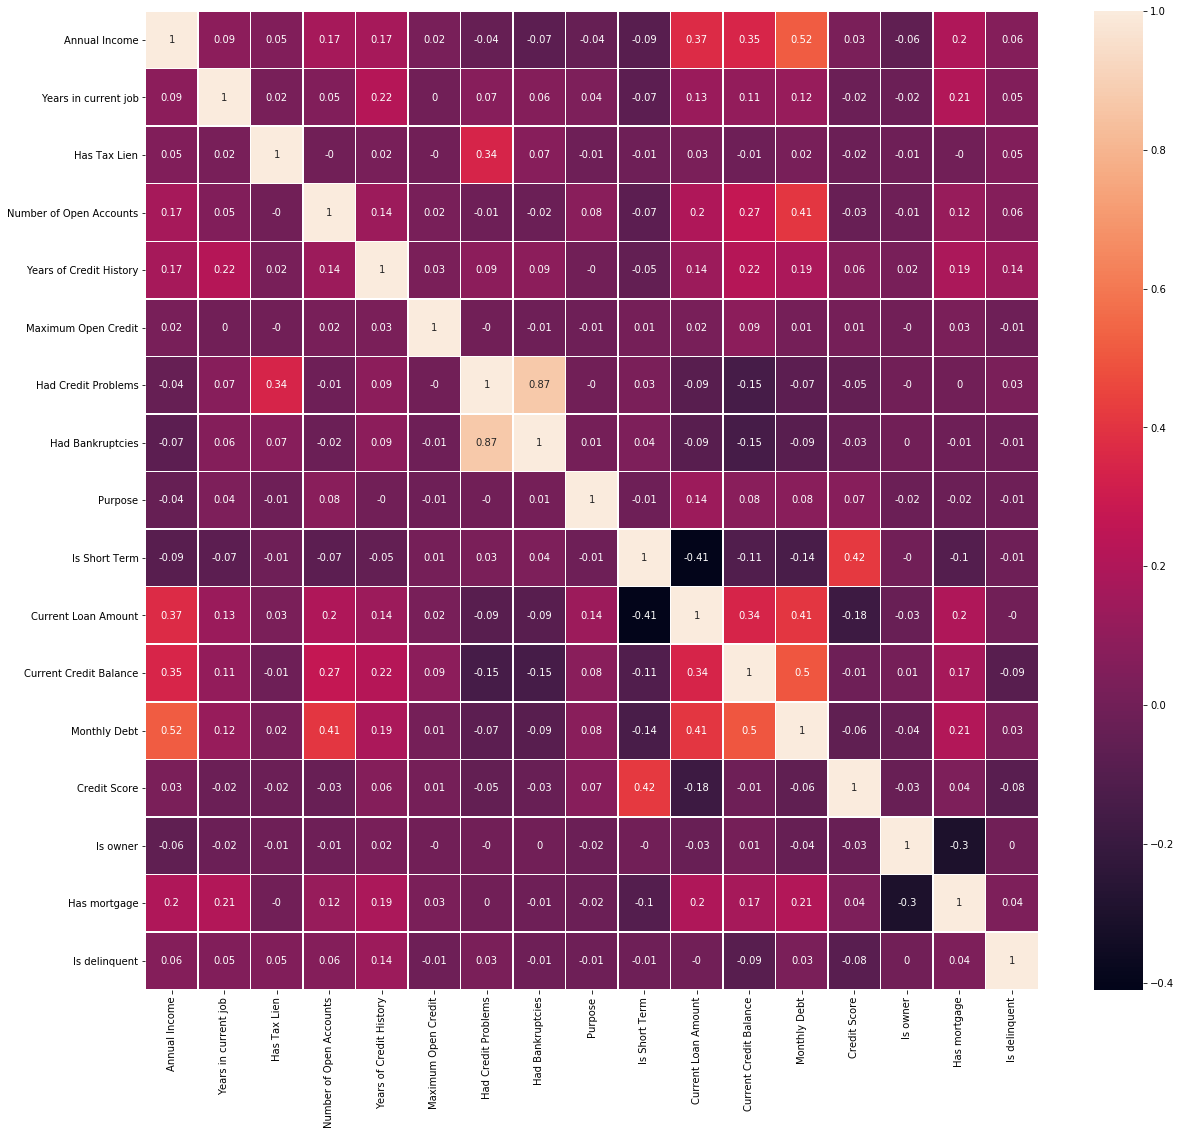

In [32]:
# матрица корреляций

rcParams['figure.figsize'] = 20, 18
sns.heatmap(train_df.drop(features_to_drop + [target], axis='columns').corr().round(2), annot=True, linewidth=.5)

In [100]:
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES =train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [97]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

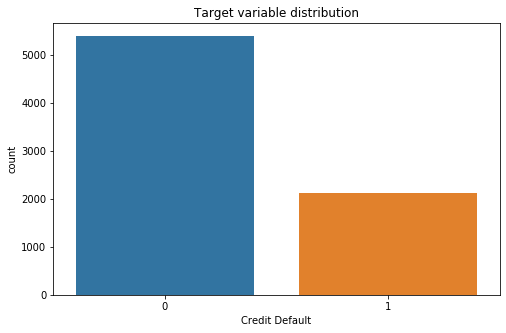

In [99]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Target variable distribution')
plt.show()

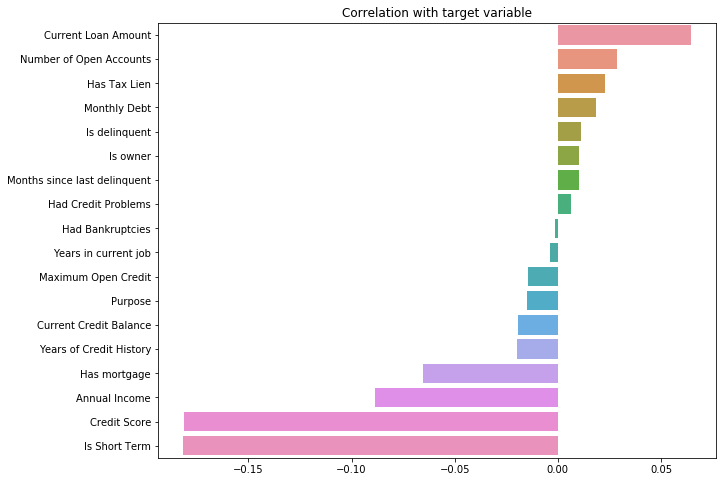

In [102]:
# Корреляция с базовыми признаками

corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

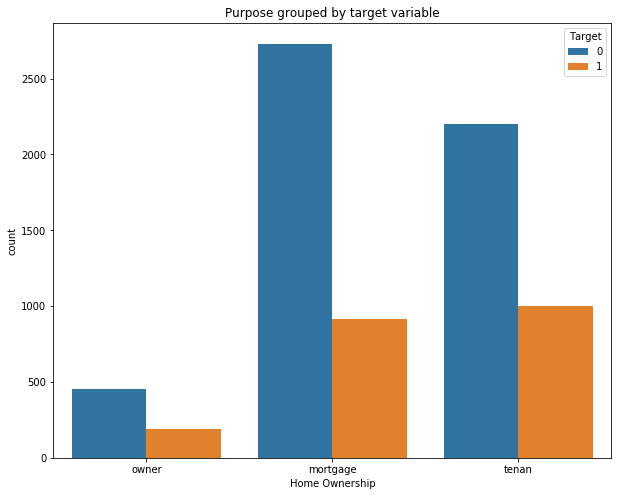

In [107]:
# Оценка признака "Purpose" в разрезе целевой переменной*

plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения mortgage и tenan признака Home ownership имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий mortgage и tenan признака Home ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [163]:
# *Сформируем выборку и рассчитаем наблюдаемые частоты*
ho_and_target_s = train_df.loc[train_df['Home Ownership'].isin(['mortgage', 'tenan']), ['Home Ownership', target]].sample(1000)

In [160]:
ho_and_target_s['ID'] = ho_and_target_s.index
table = ho_and_target_s.reindex().pivot_table(values='ID', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
mortgage,390,132
tenan,319,159


In [161]:
# Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.005540272019255935

P-value получилось меньше выбранного уровня значимости, соответственно у нас нет оснований для принятия нулевой гипотезы и нельзя допустить, что категории mortgage и tenan одинаково влияют на целевую переменную и их нельзя объединить в одну категорию.